In [1]:
import time
start_time=time.time()

In [2]:
from pathlib import Path
import numpy as np
import json
from astropy.io import fits
from astropy.utils.misc import JsonCustomEncoder
import astropy.units as u
from matplotlib import pyplot as plt
import seaborn as sns
import sys
import turbustat.statistics as tss
from turbustat.statistics import PowerSpectrum
from turbustat.io.sim_tools import create_fits_hdu
import bfunc
import pandas as pd
from rebin_utils import downsample, oversample
from astropy.modeling import models, fitting
fitter = fitting.LevMarLSQFitter()


In [3]:
#distance = 840000 #parsecs
#pix = 0.26 #arcsec 

In [4]:
name = 'N604'
element = 'H'
em_line = 'H$α$'



In [5]:
name_file = 'TAU-N604-H-mod.fits'
name_res = 'TAU-N604-H'
flux_map = 'TAURUS-604-Ha-Flux.fits'

In [6]:
##Open observations.fits
##Path and name
datapath_obs= Path(open("path-observations.txt", "r").read()).expanduser()
#name_file = 'TAU-N604-H-mod.fits'
##load obs
obs =fits.open(datapath_obs / name_file)
##Obs data to matrix array
sb = obs[1].data.astype(float)
vv = obs[2].data.astype(float)
##load header data
hdr = obs[0].header
distance = hdr['distance']

Text(51.0, 0.5, 'Y')

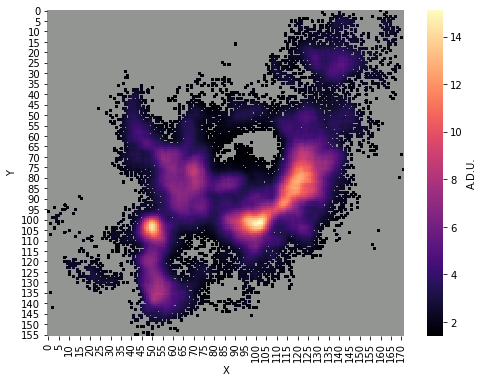

In [7]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()
sns.heatmap(sb, cmap="magma",cbar_kws={'label': 'A.D.U.'})
ax.set_facecolor('xkcd:gray')
ax.set_xlabel('X')
ax.set_ylabel('Y')

Text(51.0, 0.5, 'Y')

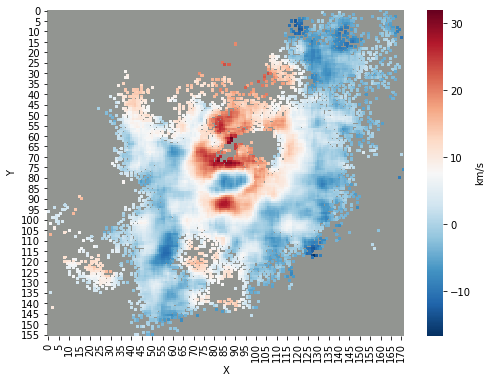

In [8]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()
sns.heatmap(vv, cmap="RdBu_r",cbar_kws={'label': 'km/s'})
ax.set_facecolor('xkcd:gray')
ax.set_xlabel('X')
ax.set_ylabel('Y')

In [9]:
##Open results.json file
##Path and name
datapath_data = Path(open("path-results.txt", "r").read()).expanduser()
#name_res = 'TAU-N604-H' ##change place to the first lines
##Load results
data = json.load(open(str(datapath_data) + '/' + name_res + ".json"))
##load  parameters derived from the fit
r0 = data["results_2sig"]['r0'][0] #pc
s0 = data["results_2sig"]['s0'][0] #pc
m = data["results_2sig"]['m'][0] #-
mer = data["results_2sig"]['m'][1] #-
sig2 = data["results_2sig"]['sig2'][0] #km^2/s^2
noise = data["results_2sig"]['noise'][0] #km^2/s^2
box_size = data["properties"]['box_size']
r0,s0,m,mer,sig2,box_size

(12.087616191694696,
 2.107818040238321,
 0.775074718298354,
 0.20739683346508753,
 85.86874995967015,
 173.44190041817617)

mf = ~np.isfinite(sb) | (sb < 0.0)
sb[mf] = 0.0
sb /= sb.max()
sb /= np.nanmean(sb)

Text(51.0, 0.5, 'Y')

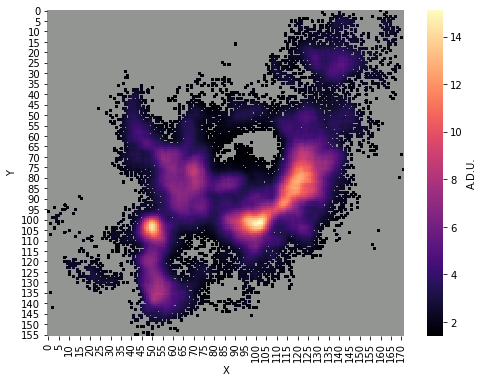

In [10]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()
sns.heatmap(sb, cmap="magma",cbar_kws={'label': 'A.D.U.'})
ax.set_facecolor('xkcd:gray')
ax.set_xlabel('X')
ax.set_ylabel('Y')

In [11]:
##nan values to mean velocity values
vmed = np.nanmedian(vv)
mv = np.isfinite(vv)
vv[~mv] = vmed

Text(51.0, 0.5, 'Y')

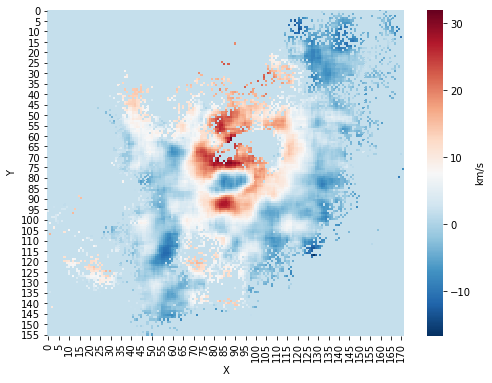

In [12]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()
sns.heatmap(vv, cmap="RdBu_r",cbar_kws={'label': 'km/s'})
ax.set_facecolor('xkcd:gray')
ax.set_xlabel('X')
ax.set_ylabel('Y')

In [13]:
##Tutorial data
##img_hdu = create_fits_hdu(img, pixel_scale, beamfwhm, imshape, restfreq, bunit)
#img_hdu = create_fits_hdu(vv,pix*u.arcsec,1 * u.arcsec, vv.shape, 1 * u.Hz, u.K)
#img_hdu.header
#pspec = PowerSpectrum(img_hdu, distance=distance* u.pc) 

Spatial Power Spectrum

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     117.8
Date:                Mon, 23 Jan 2023   Prob (F-statistic):           2.20e-18
Time:                        20:07:15   Log-Likelihood:                 55.837
No. Observations:                  98   AIC:                            -107.7
Df Residuals:                      96   BIC:                            -102.5
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4938      0.053     84.309      0.0

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\turbustat\statistics\elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


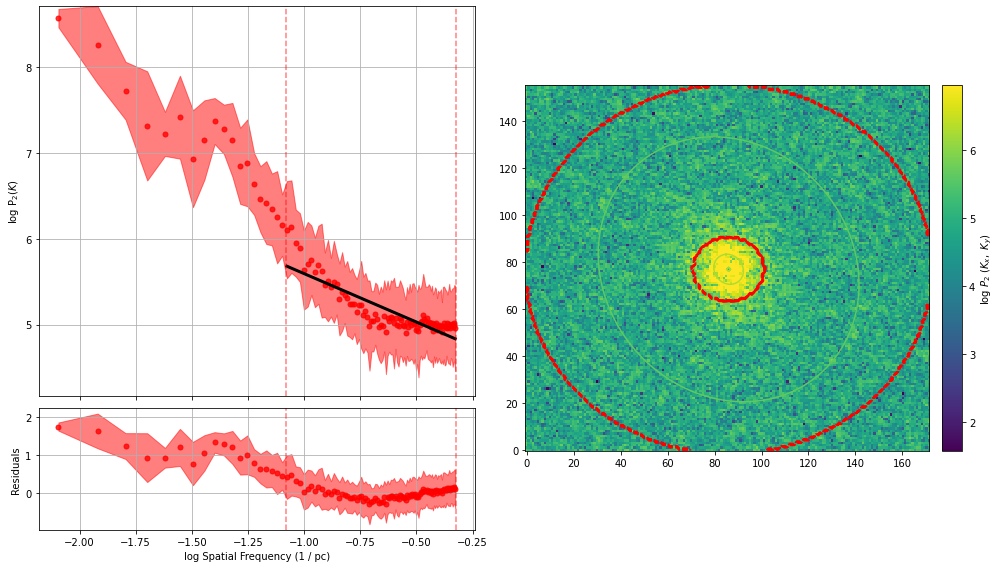

In [14]:
plt.figure(figsize=(14, 8))
pspec = PowerSpectrum(vv, header = hdr, distance=distance* u.pc) 
pspec.run(verbose=True, xunit=u.pc**-1, low_cut=(r0*u.pc)**-1, high_cut=(s0*u.pc)**-1)

In [15]:
pspec.slope

-1.1287509180060722

In [16]:
(r0*u.pc)**-1,(s0*u.pc)**-1,0.01*(u.pc)**-1

(<Quantity 0.0827293 1 / pc>,
 <Quantity 0.47442425 1 / pc>,
 <Quantity 0.01 1 / pc>)

In [17]:
np.log10(1/s0)*(u.pc)**-1,-1.75*(u.pc)**-1,-1.0*(u.pc)**-1

(<Quantity -0.32383312 1 / pc>, <Quantity -1.75 1 / pc>, <Quantity -1. 1 / pc>)

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1483.
Date:                Mon, 23 Jan 2023   Prob (F-statistic):           5.96e-90
Time:                        20:07:16   Log-Likelihood:                 84.692
No. Observations:                 116   AIC:                            -161.4
Df Residuals:                     112   BIC:                            -150.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2277      0.060     53.595      0.0

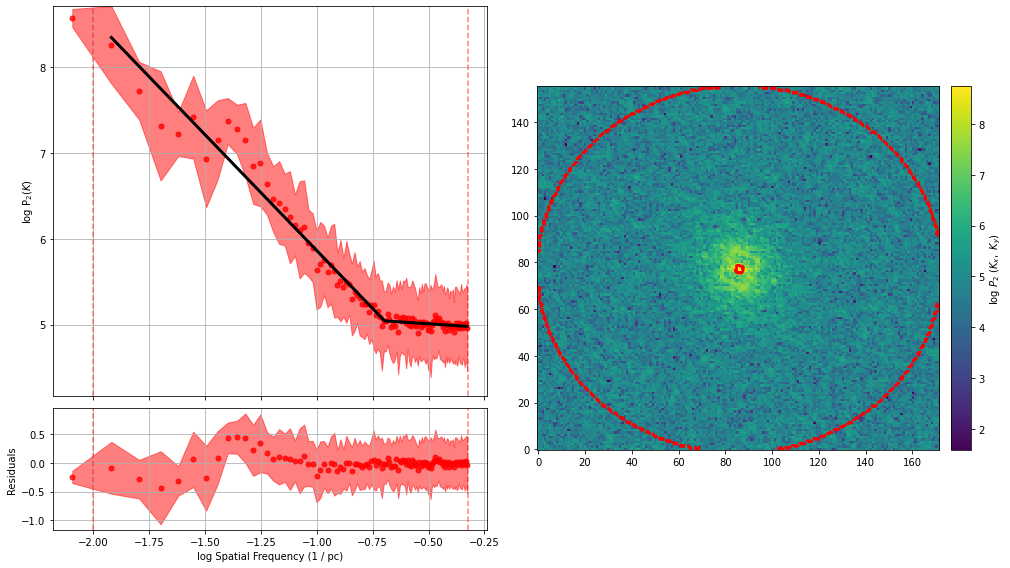

In [18]:
plt.figure(figsize=(14, 8))
pspec1 = PowerSpectrum(vv, header = hdr, distance=distance * u.pc) 
pspec1.run(verbose=True, xunit=(u.pc)**-1, low_cut=0.01*(u.pc)**-1, high_cut=(1/s0)*(u.pc)**-1,
          fit_kwargs={'brk': (1/r0)*(u.pc)**-1, 'log_break': False}, fit_2D=False)  

Delta-Variance

In [19]:
dvar = tss.DeltaVariance(vv, header = hdr, distance=distance* u.pc,nlags=50)

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.985
Model:                            WLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     532.0
Date:                Mon, 23 Jan 2023   Prob (F-statistic):           2.35e-15
Time:                        20:07:23   Log-Likelihood:                 50.944
No. Observations:                  21   AIC:                            -97.89
Df Residuals:                      19   BIC:                            -95.80
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8619      0.030    -29.021      0.0

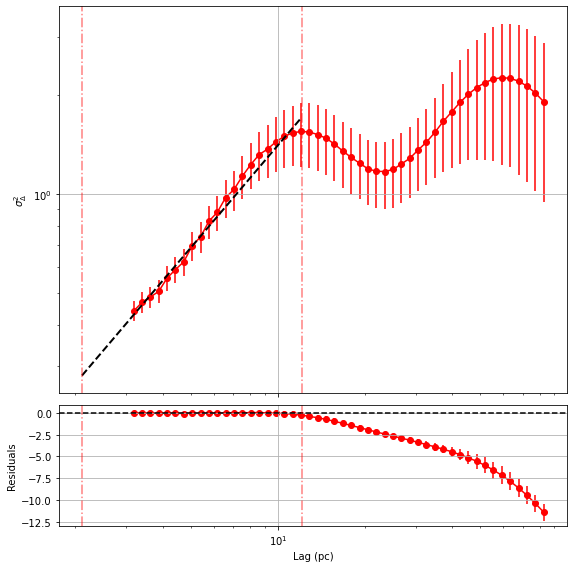

In [20]:
plt.figure(figsize=(8, 8))
dvar.run(verbose=True, boundary="fill",xunit=u.pc, xlow=s0*u.pc, xhigh=r0*u.pc)

In [21]:
sns.set_context("talk", font_scale=1.1)
#plt.style.use(["seaborn-poster",])

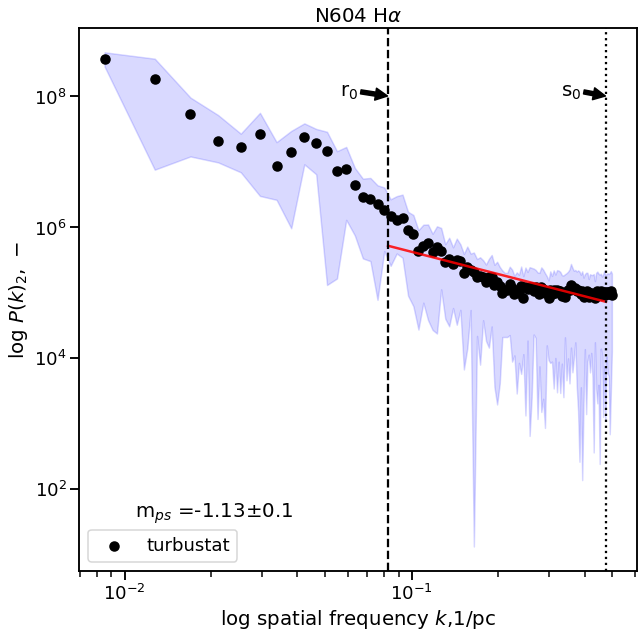

In [22]:
fig, (ax) = plt.subplots(
    1,
    1,
    sharey=False,
    figsize=(10, 10),
)

##spatial power spectra
ax.scatter(pspec.freqs,pspec.ps1D, color = 'k',label = 'turbustat')

##spatial power spectra errors
yy1 = pspec.ps1D+pspec.ps1D_stddev
yy2 = np.sqrt((pspec.ps1D-pspec.ps1D_stddev)**2)
ax.fill_between(pspec.freqs, yy1, yy2, alpha = 0.15, zorder = 0, color = 'b')

##ps-fit
xgrid = np.linspace(1/s0,1/r0,100)
ax.plot(xgrid,(10**(4.49))*(xgrid**pspec.slope), color = 'r', alpha = 0.85, linewidth = 2.5)

##seeing and corelation length
ax.axvline(1/r0, c="k", linestyle = '--')
ax.axvline(1/s0, c="k", linestyle = ':')

##annotations
ax.text(.1, .10,'m$_{ps}$ =' + str(np.round(pspec.slope,2)) + '$\pm$' + str(np.round(pspec.slope_err,2)), transform=ax.transAxes)

ax.annotate('r$_0$', xy=(1/r0, 1e8),  xycoords='data',
           xytext=(0.5, 0.9), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.02),
            horizontalalignment='right', verticalalignment='top',
            )

ax.annotate('s$_0$', xy=(1/s0, 1e8),  xycoords='data',
            xytext=(0.90, 0.9), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.02),
            horizontalalignment='right', verticalalignment='top',
            )

plt.title(name + ' '+ em_line)
plt.legend(loc = 0)

##config
ax.set(xscale='log', yscale='log', 
       xlabel='log spatial frequency $k$,1/pc',
       ylabel=r'log $P(k)_2,\ \mathrm{-}$'
      )

plt.savefig('Imgs//'+ 'ps_'+ name + element +  '.pdf', bbox_inches='tight')

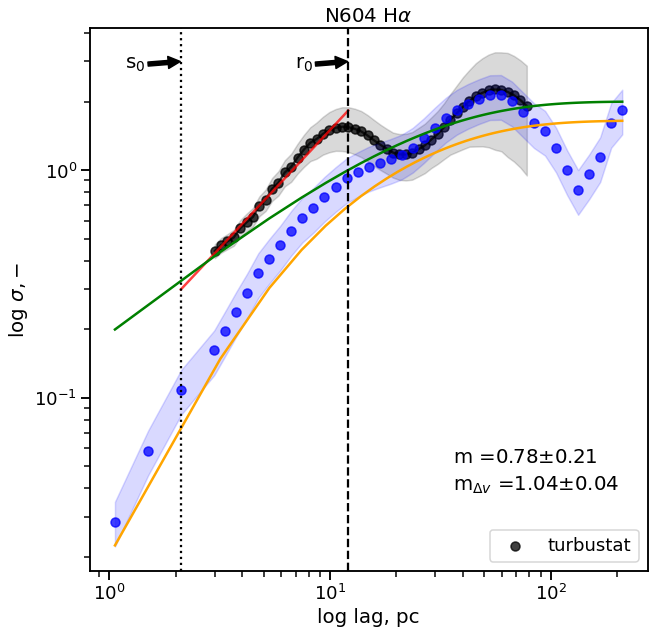

In [23]:
fig, (axx) = plt.subplots(
    1,
    1,
    sharey=False,
    figsize=(10, 10),
)

##delta-variance
axx.scatter(dvar.lags,dvar.delta_var,alpha = 0.75, color = 'k', zorder = 0, label = 'turbustat')
axx.plot(dvar.lags,dvar.delta_var,alpha = 0.75, color = 'k', zorder = 0)
yy1 = dvar.delta_var+dvar.delta_var_error
yy2 = dvar.delta_var-dvar.delta_var_error
axx.fill_between(dvar.lags, yy1, yy2, alpha = 0.15, zorder = 0, color = 'k')

##delta-fit
xgrid = np.linspace(s0,r0,100)
axx.plot(xgrid,(10**(-0.86))*(xgrid**dvar.slope), color = 'r', alpha = 0.75, linewidth = 2.5)


##observational structure function: average between sig obs and sig derived normalized
b_sigo = np.array(data['B'])/data['preres']['sig2']
b_sigd = np.array(data['B'])/sig2
b_m = ( b_sigo + b_sigd ) / 2
axx.scatter(data['r'],b_m, color = 'b', alpha = 0.75, marker = 'o')
axx.fill_between(data['r'], b_sigo , b_sigd, alpha = 0.15, zorder = 0, color = 'b')


##model structure function
rgrid = np.linspace(np.array(data['r']).min(),np.array(data['r']).max(),100)
axx.plot(rgrid, bfunc.bfunc00s(rgrid, r0, sig2, m)/sig2, color="green",  linewidth = 2.5)
axx.plot(rgrid, bfunc.bfunc04s(rgrid, r0, sig2, m, s0, noise, box_size)/sig2, color="orange",  linewidth = 2.5)

##annotations
axx.text(.65, .10,'m$_{Δv}$ =' + str(np.round(dvar.slope,2)) + '$\pm$' + str(np.round(dvar.slope_err,2)), transform=ax.transAxes)
axx.text(.65, .15,'m =' + str(np.round(m,2)) + '$\pm$' + str(np.round(mer,2)), transform=ax.transAxes)

axx.annotate('r$_0$', xy=(r0, 3),  xycoords='data',
           xytext=(0.40, 0.95), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.02),
            horizontalalignment='right', verticalalignment='top',
            )

axx.annotate('s$_0$', xy=(s0, 3),  xycoords='data',
            xytext=(0.10, 0.95), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.02),
            horizontalalignment='right', verticalalignment='top',
            )

##config
axx.set(xscale='log', yscale='log', 
       xlabel='log lag, pc',
       ylabel=r'log $σ, \mathrm{-}$'
      )

axx.axvline(r0, c="k", linestyle = '--')
axx.axvline(s0, c="k", linestyle = ':')

plt.title(name + ' '+ em_line)
plt.legend(loc = 4)

plt.savefig('Imgs//'+ 'sf_'+ name + element +  '.pdf', bbox_inches='tight')

In [24]:
#sb = fits.open(datapath_obs / 'TAURUS-604-Ha-Flux.fits')[0].data.astype(float)
#mf = ~np.isfinite(sb) | (sb < 0.0)
#sb[mf] = 0.0
#sb /= sb.max()
#sb /= np.nanmean(sb)

PDF/CFD

In [25]:
#header=0
input_data = (sb,hdr) 

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\turbustat\statistics\pdf\compare_pdf.py:57: RuntimeWarning: invalid value encountered in greater
  output_data > min_val)


Optimization terminated successfully.
         Current function value: 0.597734
         Iterations: 19
         Function evaluations: 39
                              Likelihood Results                              
Dep. Variable:                      y   Log-Likelihood:                -5684.5
Model:                     Likelihood   AIC:                         1.137e+04
Method:            Maximum Likelihood   BIC:                         1.140e+04
Date:                Mon, 23 Jan 2023                                         
Time:                        20:07:26                                         
No. Observations:                9510                                         
Df Residuals:                    9508                                         
Df Model:                           2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

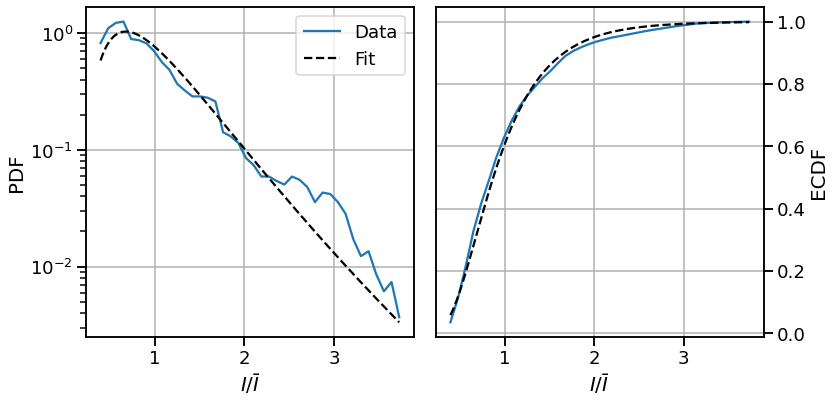

In [26]:
pdf_mom0 = tss.PDF(input_data, min_val=0.0, bins=40, normalization_type= "normalize_by_mean" )
plt.figure(figsize=(12, 6))
pdf_mom0.run(verbose=True)

In [27]:
from scipy.stats import lognorm
import seaborn as sns
sns.set_color_codes()
sns.set_context("talk")

In [28]:
LN = lognorm(s=1.0, scale=np.exp(1.0))

[None]

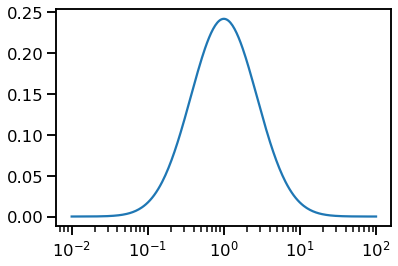

In [29]:
x = np.logspace(-2.0, 2.0, 300)
fig, ax = plt.subplots()
ax.plot(x, LN.pdf(x))
ax.set(xscale="log")

In [30]:
len(pdf_mom0.bins)

40

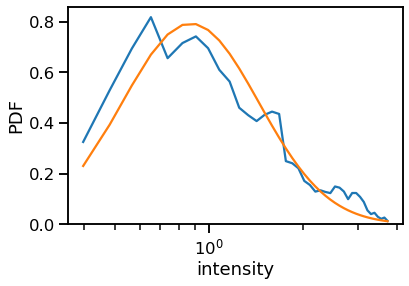

In [31]:
fig, ax = plt.subplots()
s, scale = pdf_mom0.model_params
LN = lognorm(s=s, scale=scale)
x = pdf_mom0.bins
ax.plot(x, x*pdf_mom0.pdf)
ax.plot(x, x*LN.pdf(x))
ax.set(
    xlabel="intensity",
    ylabel="PDF",
    xscale="log",
    ylim=[0, None],
);

In [32]:
pdf_mom0.model_params

array([0.50336901, 0.87391451])

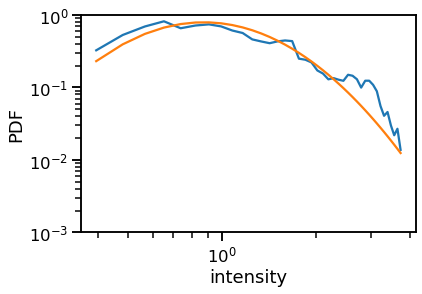

In [33]:
fig, ax = plt.subplots()
ax.plot(x, x*pdf_mom0.pdf)
ax.plot(x, x*LN.pdf(x))
ax.set(
    xlabel="intensity",
    ylabel="PDF",
    xscale="log",
    yscale="log",
    ylim=[1e-3, 1.0],
);

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\turbustat\statistics\pdf\compare_pdf.py:57: RuntimeWarning: invalid value encountered in greater
  output_data > min_val)


Optimization terminated successfully.
         Current function value: 3.937251
         Iterations: 27
         Function evaluations: 55
                              Likelihood Results                              
Dep. Variable:                      y   Log-Likelihood:                -37443.
Model:                     Likelihood   AIC:                         7.489e+04
Method:            Maximum Likelihood   BIC:                         7.491e+04
Date:                Mon, 23 Jan 2023                                         
Time:                        20:07:28                                         
No. Observations:                9510                                         
Df Residuals:                    9508                                         
Df Model:                           2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

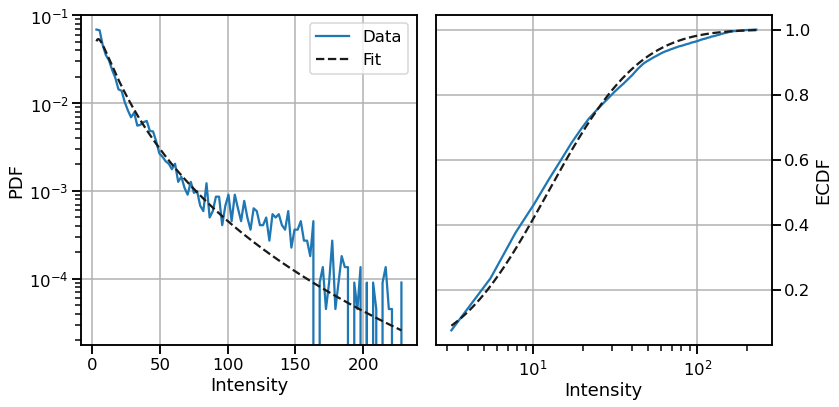

In [34]:
wpdf_mom0 = tss.PDF(input_data, min_val=0.0, weights=sb)
plt.figure(figsize=(12, 6))
wpdf_mom0.run(verbose=True)

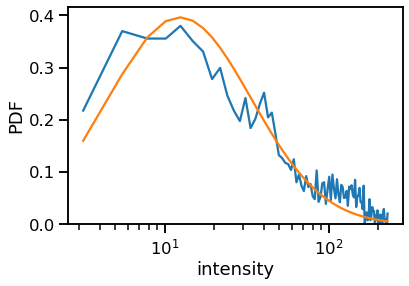

In [35]:
fig, ax = plt.subplots()
s, scale = wpdf_mom0.model_params
LN = lognorm(s=s, scale=scale)
x = wpdf_mom0.bins
ax.plot(x, x*wpdf_mom0.pdf)
ax.plot(x, x*LN.pdf(x))
ax.set(
    xlabel="intensity",
    ylabel="PDF",
    xscale="log",
    ylim=[0, None],
);

In [36]:
wpdf_mom0.model_params

array([ 1.00673802, 12.32460298])

<ipython-input-37-b938c8db92ba>:1: RuntimeWarning: invalid value encountered in greater
  m1 = np.isfinite(sb) & (sb > 0.0)


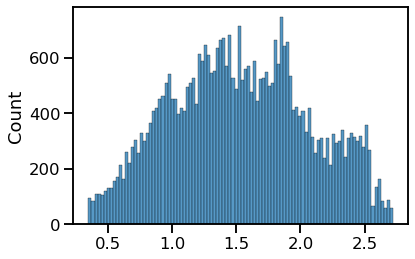

In [37]:
m1 = np.isfinite(sb) & (sb > 0.0)
sns.histplot(x=np.log(sb[m1]), kde=False, weights=sb[m1].astype(float), bins=100)

In [38]:
H, edges = np.histogram(np.log(sb[m1]), weights=sb[m1], bins=100, range=[-4.0, 2.5], density=True)

[Text(0, 0.5, 'PDF'), Text(0.5, 0, '$\\ln (S/S_0)$')]

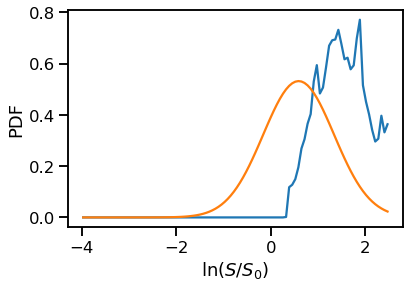

In [39]:
fig, ax = plt.subplots()
centers = 0.5*(edges[:-1] + edges[1:])
ax.plot(centers, H)
LN = lognorm(s=0.75,scale=1.8)
ax.plot(centers, np.exp(centers)*LN.pdf(np.exp(centers)))
ax.set(
    xlabel="$\ln (S/S_0)$",
    ylabel="PDF",
#    yscale="log",
#    ylim=[1e-3, 1.0],
)

[Text(0, 0.5, 'CDF'), Text(0.5, 0, '$\\ln (S/S_0)$')]

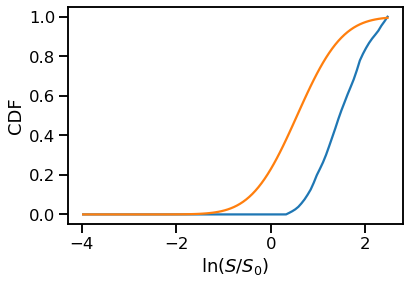

In [40]:
cdf = np.cumsum(H)*(centers[1] - centers[0])
fit = np.exp(centers)*LN.pdf(np.exp(centers))
cdf_fit = np.cumsum(fit)*(centers[1] - centers[0])

fig, ax = plt.subplots()
ax.plot(centers, cdf)
ax.plot(centers, cdf_fit)
ax.set(
    xlabel="$\ln (S/S_0)$",
    ylabel="CDF",
#    yscale="log",
#    ylim=[1e-3, 1.0],
)

[None,
 (0.0003333333333333333, 3000.0),
 Text(0, 0.5, 'CDF / (1 $-$ CDF)'),
 Text(0.5, 0, '$\\ln (S/S_0)$')]

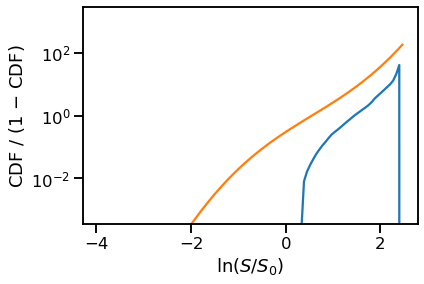

In [41]:
fig, ax = plt.subplots()
ax.plot(centers, cdf/(1 - cdf))
ax.plot(centers, cdf_fit/(1 - cdf_fit))
ax.set(
    xlabel="$\ln (S/S_0)$",
    ylabel="CDF / (1 $-$ CDF)",
    yscale="log",
    ylim=[1e-3/3, 3e3],
)

In [42]:
#from sbfluct import sbfluct
#sbfluct(sb, 1e-8, 2, "604")

In [43]:

sb = fits.open(datapath_obs / flux_map)[0].data.astype(float)
fmin = 1e-8
kmax = 2

In [44]:
resamples = [2, 4, 8, 16, 32, 64]

In [45]:
m = (sb > fmin) & np.isfinite(sb)
w = np.ones_like(sb)

In [46]:
for n in resamples[: kmax]:
    [sb,], m, w = downsample([sb,],
        m,
        weights=w,
        mingood=1,
        )
    
sb /= np.mean(sb[m])

C:\Users\ZAINTEL2\Documents\Aeon\GitHub\PhD.Paper\power_spectrum\rebin_utils.py:129: RuntimeWarning: invalid value encountered in true_divide
  (


In [47]:
smin, smax = -3.1, 3.1

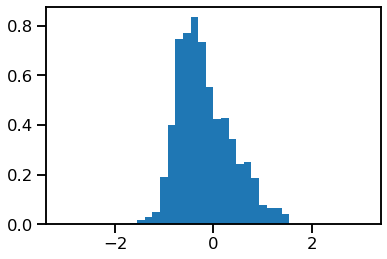

In [48]:
H, edges, patches = plt.hist(
            np.log(sb[m]),
            # weights=s[m],
            density=True,
            bins=40,
            range=[-3.1, 3.1],)



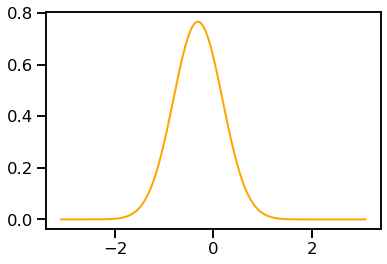

In [49]:
# Calculate bin centers
x = 0.5 * (edges[:-1] + edges[1:])
# Fit Gaussian
g = models.Gaussian1D(amplitude=H.max(), stddev=0.5)
core = H > 0.01
g = fitter(g, x, H)
sigS = np.sqrt(np.exp(g.stddev.value ** 2) - 1)
esigS = 0.5 * np.sqrt(np.exp(g.mean.value ** 2) - 1)
xx = np.linspace(smin, smax, 200)

plt.plot(xx, g(xx), "orange", lw=2)


In [50]:
X = np.exp(xx)
Xmean = np.average(X, weights=g(xx))
Xvariance = np.average((X - Xmean) ** 2, weights=g(xx))
eps_rms = np.sqrt(Xvariance) / Xmean
eps_rms 

0.533348196828465

In [51]:
##turbustat results
x = pdf_mom0.bins 
s, scale = pdf_mom0.model_params
LN = lognorm(s=s, scale=scale)

Xmean = np.average(x, weights=x*LN.pdf(x))
Xvariance = np.average((x - Xmean) ** 2, weights=x*LN.pdf(x))
eps_rms_t = np.sqrt(Xvariance) / Xmean
eps_rms_t 

0.48683421676779415

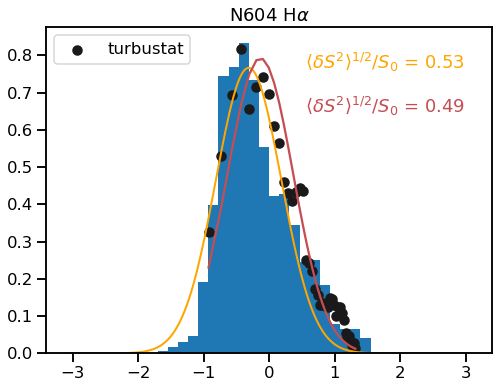

In [59]:
plt.figure(figsize=(8, 6))

##pdf
H, edges, patches = plt.hist(
            np.log(sb[m]),
            # weights=s[m],
            density=True,
            bins=40,
            range=[-3.1, 3.1],)

##lognorm fit
plt.plot(xx, g(xx), "orange", lw=2)

##pdf turbustat and fit
plt.scatter(np.log(x), x*pdf_mom0.pdf, color = 'k', zorder = 2, label = 'turbustat')
plt.plot(np.log(x), x*LN.pdf(x), color = 'r')

plt.text(.75, 1.3,r"$\langle \delta S^2 \rangle^{1/2} / S_0$ = " + str(np.round(eps_rms ,2)), transform=ax.transAxes, color = 'orange')
plt.text(.75, 1.1,r"$\langle \delta S^2 \rangle^{1/2} / S_0$ = " + str(np.round(eps_rms_t ,2)), transform=ax.transAxes, color = 'r')


plt.title(name + ' '+ em_line)
plt.legend(loc = 2)

plt.savefig('Imgs//'+ 'bf_'+ name + element +  '.pdf', bbox_inches='tight')

In [53]:
!jupyter nbconvert --to script --no-prompt ts-TAU-N604-H.ipynb

[NbConvertApp] Converting notebook ts-TAU-N604-H.ipynb to script
[NbConvertApp] Writing 12534 bytes to ts-TAU-N604-H.py


In [54]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 25.280161380767822 seconds ---
